In [21]:
import pandas as pd

# 데이터 파일 경로
file_path = '/Users/eunma/Documents/GitHub/kakaobootcamp/personal mission/NLP pipeline/data/Reviews.csv'

# 데이터 로드
data = pd.read_csv(file_path)

# 데이터 탐색
print(data.head())
print(data.info())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [23]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# NLTK 불용어 다운로드
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# 데이터 선택 (필요한 열만 사용)
data = data[['Text', 'Score']]

# 결측값 제거
data.dropna(inplace=True)

# 리뷰 텍스트 전처리 함수
def preprocess_text(text):
    text = text.lower()  # 소문자 변환
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    tokens = word_tokenize(text)  # 토큰화
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # 불용어 제거
    return ' '.join(tokens)

# 텍스트 전처리 적용
data['processed_text'] = data['Text'].apply(preprocess_text)
print(data.head())

[nltk_data] Downloading package stopwords to /Users/eunma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/eunma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                Text  Score  \
0  I have bought several of the Vitality canned d...      5   
1  Product arrived labeled as Jumbo Salted Peanut...      1   
2  This is a confection that has been around a fe...      4   
3  If you are looking for the secret ingredient i...      2   
4  Great taffy at a great price.  There was a wid...      5   

                                      processed_text  
0  bought several vitality canned dog food produc...  
1  product arrived labeled jumbo salted peanutsth...  
2  confection around centuries light pillowy citr...  
3  looking secret ingredient robitussin believe f...  
4  great taffy great price wide assortment yummy ...  


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=5000)  # 최대 특징 수를 5000으로 제한
X = vectorizer.fit_transform(data['processed_text'])
y = data['Score']

print(X.shape)

(568454, 5000)


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 레이블 이진화 (positive: 4, 5, negative: 1, 2, 3)
y = y.apply(lambda x: 1 if x > 3 else 0)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 예측
y_pred = model.predict(X_test)

# 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8921374603090834
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.66      0.73     24666
           1       0.91      0.96      0.93     89025

    accuracy                           0.89    113691
   macro avg       0.86      0.81      0.83    113691
weighted avg       0.89      0.89      0.89    113691

Confusion Matrix:
 [[16371  8295]
 [ 3968 85057]]


# 성능 지표
## 정확도
- 전체 예측에서 올바르게 예측된 비율
- Accuracy : TP + TN/ TP+ TN+ FP+ FN
- 89.2%

## 정밀도
- 양성으로 예측한 것 중 실제 양성인 비율
- Percision : TP / TP + FP
- 긍정 리뷰 91% 부정 리뷰 80%

## 재현율
- 실제 양성 모델 중에서 모델이 양성으로 올바르게 예측한 비율
- Recall : TP / TP + FN
- 양성 클래스 재현율 96%, 음성 클래스 재현율 66%

## F1-score
- 정밀도와 재현율의 조화 평균. 불균형 데이터셋에서 유용한 지표
- 2 × Precision x Recall / Precision + Recall
- 양성 F1-score : 93% , 음성 클래스의 F1 - score 73%

## 혼동 행렬(confusion Martix)
- 실제 값과 예측 값의 분포를 보여주는 표
* True Negative (TN): 16371
* False Positive (FP): 8295
* False Negative (FN): 3968
* True Positive (TP): 85057

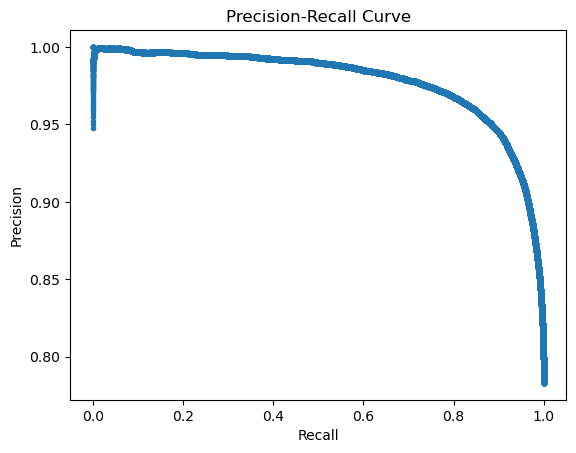

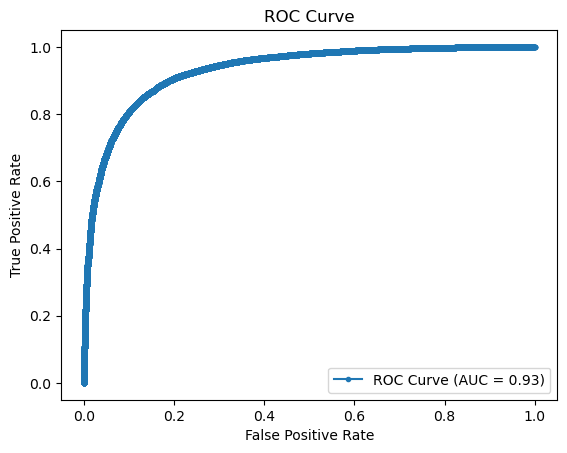

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# 정밀도-재현 (Precision-Recall Curve)
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [34]:
import pandas as pd

# 데이터 파일 경로
file_path = '/Users/eunma/Documents/GitHub/kakaobootcamp/personal mission/NLP pipeline/data/Reviews.csv'

# 데이터 로드
data = pd.read_csv(file_path)

# 데이터 탐색
print(data.head())
print(data.info())

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# NLTK 불용어 다운로드
import nltk

# 데이터 선택 (필요한 열만 사용)
data = data[['Text', 'Score']]

# 결측값 제거
data.dropna(inplace=True)

# 리뷰 텍스트 전처리 함수
def preprocess_text(text):
    text = text.lower()  # 소문자 변환
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    tokens = word_tokenize(text)  # 토큰화
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # 불용어 제거
    return ' '.join(tokens)

# 텍스트 전처리 적용
data['processed_text'] = data['Text'].apply(preprocess_text)
print(data.head())

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['processed_text'])
y = data['Score']

# 레이블 이진화 (positive: 4, 5, negative: 1, 2, 3)
y = y.apply(lambda x: 1 if x > 3 else 0)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # 정규화 강도c
    'penalty': ['l1', 'l2'],       # 페널티 유형
    'solver': ['liblinear']        # 최적화 알고리즘
}

# 로지스틱 회귀 모델 초기화
log_reg = LogisticRegression(max_iter=1000)

# 그리드 서치 설정
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# 그리드 서치 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

KeyboardInterrupt: 